In [49]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import xgboost 
from matplotlib import pyplot
from sklearn import set_config
set_config(transform_output="pandas")


In [50]:
data_path = "Dataset_analyse.csv"
df = pd.read_csv(data_path)

df = df.drop(['month','day',"title","total_spectator",'distributor','country','director','director_score',"hebdo_rank","first_day","first_weekend","rating_public","casting","visa","award","lang"], axis=1)
df = df.dropna()

df

,year,duration,genre,first_week,copies,rating_press,budget,entree_annee,classification_acteurs,classification_country,season,is_holiday
0,1997,6300,thriller,172230,234,2.528571,8.067143e+08,149.3,0.0,2,winter,0
1,1999,5400,drame,154881,198,3.400000,1.416571e+09,153.6,0.0,2,winter,0
2,1994,5220,comedie,417021,189,2.771429,3.207143e+07,124.4,2.0,2,winter,0
3,1995,9900,aventure action,355642,302,2.600000,2.172143e+08,130.2,0.0,3,winter,0
4,1994,9120,comedie dramatique,101953,129,3.200000,3.278571e+07,124.4,0.0,0,winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3627,1997,5520,film familial,129374,248,2.928571,1.167714e+09,149.3,0.0,3,winter,0
3628,1994,6060,aventure action,186581,264,2.228571,3.850000e+07,124.4,0.0,3,winter,0
3629,1994,6480,film familial,227393,123,3.000000,2.013571e+08,132.7,0.0,3,winter,0
3630,2008,7080,comedie,110442,128,3.900000,4.137286e+07,190.3,0.0,0,winter,1


In [51]:

# Créer la colonne hebdomadaire en divisant first_weekend par 2000
df['hebdomadaire'] = df['first_week'] / 2000

# Définition des taux de diminution pour chaque jour de la semaine
taux_diminution_jour = {
    'lundi': 0.15,   # 15% de diminution le lundi
    'mardi': 0.12,   # 12% de diminution le mardi
    'mercredi': 0.10,  # 10% de diminution le mercredi
    'jeudi': 0.08,   # 8% de diminution le jeudi
    'vendredi': 0.05,  # 5% de diminution le vendredi
    'samedi': 0.03,  # 3% de diminution le samedi
    'dimanche': 0.02  # 2% de diminution le dimanche
}

# Créer les 7 colonnes pour les estimations journalières
for jour, taux_diminution in taux_diminution_jour.items():
    df[jour] = df['hebdomadaire'] / 7  # Division par 7 pour obtenir les estimations journalières
    df[jour] *= (1 - taux_diminution)  # Appliquer le taux de diminution pour chaque jour

df = df.sort_values(by='hebdomadaire', ascending=False)
df

,year,duration,genre,first_week,copies,rating_press,budget,entree_annee,classification_acteurs,classification_country,season,is_holiday,hebdomadaire,lundi,mardi,mercredi,jeudi,vendredi,samedi,dimanche
343,2008,6360,comedie,4378720,793,3.6,1.100000e+07,190.3,2.0,2,winter,0,2189.3600,265.850857,275.233829,281.489143,287.744457,297.127429,303.382743,306.51040
3445,2006,5820,comedie,3906694,950,2.7,4.237286e+07,188.8,0.0,2,winter,0,1953.3470,237.192136,245.563623,251.144614,256.725606,265.097093,270.678084,273.46858
1580,2015,8160,fantasy,3801235,1093,4.0,4.137286e+07,205.4,0.0,3,winter,0,1900.6175,230.789268,238.934771,244.365107,249.795443,257.940946,263.371282,266.08645
2580,2002,6420,comedie,3685097,945,3.8,4.137286e+07,184.4,2.0,2,winter,0,1842.5485,223.738032,231.634669,236.899093,242.163517,250.060154,255.324578,257.95679
1882,2000,5400,comedie,3478850,831,2.8,4.192857e+08,165.8,0.0,2,winter,0,1739.4250,211.215893,218.670571,223.640357,228.610143,236.064821,241.034607,243.51950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,1999,7020,thriller,100318,247,3.0,3.500000e+07,153.6,3.0,3,winter,0,50.1590,6.090736,6.305703,6.449014,6.592326,6.807293,6.950604,7.02226
1232,2012,6480,drame,100221,164,3.6,4.137286e+07,203.6,2.0,2,winter,0,50.1105,6.084846,6.299606,6.442779,6.585951,6.800711,6.943884,7.01547
3514,2010,9600,science fiction,53756,78,4.3,2.370000e+08,207.1,0.0,3,winter,1,26.8780,3.263757,3.378949,3.455743,3.532537,3.647729,3.724523,3.76292
3584,2000,-1,drame,43203,84,4.1,1.027571e+09,165.8,0.0,2,winter,0,21.6015,2.623039,2.715617,2.777336,2.839054,2.931632,2.993351,3.02421


In [52]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing)#, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [53]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [54]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['genre',
                                                                    'season']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(with_centerin...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

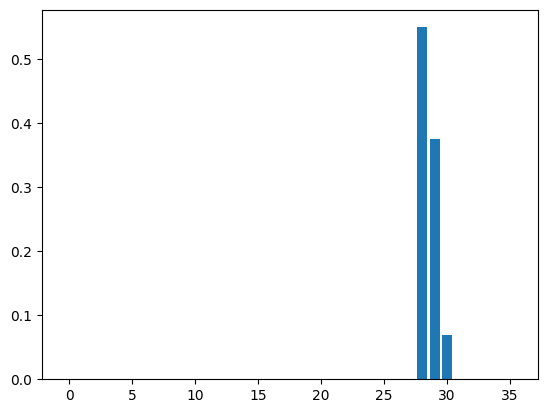

In [55]:
pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
pyplot.show()

In [56]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [57]:
xtrain_tr.columns

Index(['categorical__genre_animation', 'categorical__genre_aventure action',
       'categorical__genre_catastrophe', 'categorical__genre_comedie',
       'categorical__genre_comedie dramatique', 'categorical__genre_comicbook',
       'categorical__genre_documentaire', 'categorical__genre_drame',
       'categorical__genre_fantasy', 'categorical__genre_film familial',
       'categorical__genre_guerre', 'categorical__genre_horreur',
       'categorical__genre_musical', 'categorical__genre_peplum',
       'categorical__genre_romance', 'categorical__genre_science fiction',
       'categorical__genre_thriller', 'categorical__genre_western',
       'categorical__season_winter', 'numerical__year', 'numerical__duration',
       'numerical__copies', 'numerical__rating_press', 'numerical__budget',
       'numerical__entree_annee', 'numerical__classification_acteurs',
       'numerical__classification_country', 'numerical__is_holiday',
       'numerical__hebdomadaire', 'numerical__lundi', 'nume

In [58]:
pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

categorical__genre_animation             3.690342e-05
categorical__genre_aventure action       3.265284e-04
categorical__genre_catastrophe           6.194823e-05
categorical__genre_comedie               7.676447e-05
categorical__genre_comedie dramatique    1.104989e-04
categorical__genre_comicbook             2.521815e-04
categorical__genre_documentaire          2.487952e-06
categorical__genre_drame                 3.244361e-05
categorical__genre_fantasy               3.181930e-04
categorical__genre_film familial         3.473927e-05
categorical__genre_guerre                6.760519e-05
categorical__genre_horreur               9.476319e-06
categorical__genre_musical               5.057242e-06
categorical__genre_peplum                3.967029e-06
categorical__genre_romance               8.095840e-06
categorical__genre_science fiction       9.542013e-04
categorical__genre_thriller              3.008092e-05
categorical__genre_western               3.046822e-06
categorical__season_winter  

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

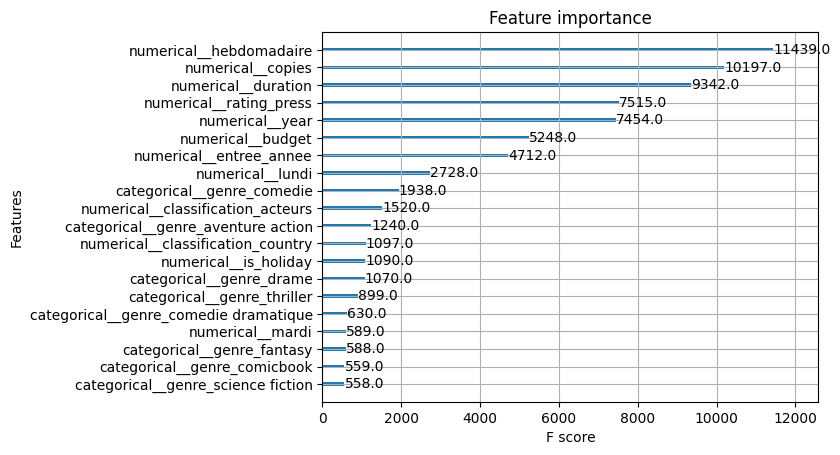

In [59]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [60]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [61]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.9887
MAE: 7109.39
RMSE: 48239.21


In [62]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [63]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2023,'summer', 180.8,1,7, 19, 1, "etatsunis",3,3, 6840, "film familial", 665, 3.4, 100000000, 3]])

ValueError: columns are missing: {'lundi', 'mardi', 'mercredi', 'hebdomadaire', 'jeudi', 'samedi', 'vendredi', 'dimanche'}